# Adversarial Attacks - Patches

## Alejandro Paredes La Torre

Disclaimer: This tutorial was originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University.

Below you will find some modifications I did for my own patch


### Disclosure
AI was used to speed up the coding process.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AAlejandroParedesLT/adversarial_patches/blob/main/adversarial_attacks_patches.ipynb)


In [27]:

## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-551110126.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [28]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


In [29]:
import os
import urllib.request
from urllib.error import HTTPError

TARGET_DIR = "data_imagenet"
os.makedirs(TARGET_DIR, exist_ok=True)

fname = "imagenet_classes.txt"
file_url = "https://raw.githubusercontent.com/AIPI-590-XAI/Duke-AI-XAI/refs/heads/main/adversarial-ai-example-notebooks/imagenet_classes.txt"
file_path = os.path.join(TARGET_DIR, fname)

if not os.path.isfile(file_path):
    print(f"Downloading {file_url}...")
    try:
        urllib.request.urlretrieve(file_url, file_path)
        print("Download complete.")
    except HTTPError as e:
        print("Download failed with HTTP error:", e)

print("Saved at:", file_path)


Download complete.
Saved at: data_imagenet/imagenet_classes.txt


## Custom Setup

For my experiments I am going to use a wide range of models to evaluate how each one of them performs and which one is better at helping me create my adversarial patch.

### List of models to be tested:

**Core ImageNet models:**

* VGG16 (`vgg16`)
* VGG19 with batch normalization (`vgg19_bn`)
* AlexNet (`alexnet`)

**EfficientNet family:**

* EfficientNet-B0 (`efficientnet_b0`)
* EfficientNet-B1 (`efficientnet_b1`)

**Mobile-oriented models:**

* MobileNet V2 (`mobilenet_v2`)
* MobileNet V3 Small (`mobilenet_v3_small`)
* SqueezeNet 1.1 (`squeezenet1_1`)
* ShuffleNet V2 X1.0 (`shufflenet_v2_x1_0`)

**CNN baselines:**

* ResNet34 (`resnet34`)
* ResNet50 (`resnet50`)
* GoogLeNet (`googlenet`)

**RegNet:**

* RegNet Y 3.2GF (`regnet_y_3_2gf`)

**Vision Transformer:**

* ViT-B16 (`vit_b_16`)

**Swin Transformer:**

* Swin-T (`swin_t`)


In [34]:
import os
import torch
import torchvision

os.environ["TORCH_HOME"] = CHECKPOINT_PATH

# Core ImageNet models
model_vgg16 = torchvision.models.vgg16(weights="IMAGENET1K_V1").to(device)
model_vgg19_bn = torchvision.models.vgg19_bn(weights="IMAGENET1K_V1").to(device)
model_alexnet = torchvision.models.alexnet(weights="IMAGENET1K_V1").to(device)

# EfficientNet family
model_efficientnet_b0 = torchvision.models.efficientnet_b0(weights="IMAGENET1K_V1").to(device)
model_efficientnet_b1 = torchvision.models.efficientnet_b1(weights="IMAGENET1K_V1").to(device)

# Mobile oriented
model_mobilenet_v2 = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V1").to(device)
model_mobilenet_v3_small = torchvision.models.mobilenet_v3_small(weights="IMAGENET1K_V1").to(device)
model_squeezenet = torchvision.models.squeezenet1_1(weights="IMAGENET1K_V1").to(device)
model_shufflenet = torchvision.models.shufflenet_v2_x1_0(weights="IMAGENET1K_V1").to(device)

# CNN baselines
model_resnet34 = torchvision.models.resnet34(weights="IMAGENET1K_V1").to(device)
model_resnet50 = torchvision.models.resnet50(weights="IMAGENET1K_V1").to(device)
model_googlenet = torchvision.models.googlenet(weights="IMAGENET1K_V1").to(device)

# RegNet (pick one)
model_regnet = torchvision.models.regnet_y_3_2gf(weights="IMAGENET1K_V1").to(device)

# Vision Transformer
model_vit = torchvision.models.vit_b_16(weights="IMAGENET1K_V1").to(device)

# Swin Transformer (pick one)
model_swin = torchvision.models.swin_t(weights="IMAGENET1K_V1").to(device)

# Freeze
models = [
    model_vgg16,
    model_vgg19_bn,
    model_alexnet,
    model_efficientnet_b0,
    model_efficientnet_b1,
    model_mobilenet_v2,
    model_mobilenet_v3_small,
    model_squeezenet,
    model_shufflenet,
    model_resnet34,
    model_resnet50,
    model_googlenet,
    model_regnet,
    model_vit,
    model_swin
]

for m in models:
    m.eval()
    for p in m.parameters():
        p.requires_grad = False


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to ./saved_models/tutorial10/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 128MB/s]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to ./saved_models/tutorial10/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 210MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to ./saved_models/tutorial10/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 195MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to ./saved_models/tutorial10/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 226MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to ./saved_models/tutorial10/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 234MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to ./saved_models/tutorial10/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 216MB/s]


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to ./saved_models/tutorial10/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


100%|██████████| 4.73M/4.73M [00:00<00:00, 184MB/s]

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to ./saved_models/tutorial10/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth



100%|██████████| 8.79M/8.79M [00:00<00:00, 215MB/s]


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ./saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to ./saved_models/tutorial10/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 37.4MB/s]


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to ./saved_models/tutorial10/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 204MB/s]


Downloading: "https://download.pytorch.org/models/regnet_y_3_2gf-b5a9779c.pth" to ./saved_models/tutorial10/hub/checkpoints/regnet_y_3_2gf-b5a9779c.pth


100%|██████████| 74.6M/74.6M [00:05<00:00, 14.1MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to ./saved_models/tutorial10/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:05<00:00, 59.3MB/s]


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to ./saved_models/tutorial10/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:00<00:00, 213MB/s] 


To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same [license](http://image-net.org/download-faq) as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [39]:
import os
import json
import numpy as np
from typing import Tuple
import torch
from torch.utils import data
import torchvision
from torchvision import transforms, datasets

device = torch.device("cuda") or torch.device("cpu")

os.environ["TORCH_HOME"] = CHECKPOINT_PATH

imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find dataset at {imagenet_path}"

NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD  = np.array([0.229, 0.224, 0.225])

dataset =

# Model registry. Each entry maps a model key to a callable that instantiates the model
# and to the corresponding Weights enum from torchvision.
model_registry = {
    "vgg16": {
        "constructor": torchvision.models.vgg16,
        "weights": torchvision.models.VGG16_Weights.IMAGENET1K_V1
    },
    "vgg19_bn": {
        "constructor": torchvision.models.vgg19_bn,
        "weights": torchvision.models.VGG19_BN_Weights.IMAGENET1K_V1
    },
    "alexnet": {
        "constructor": torchvision.models.alexnet,
        "weights": torchvision.models.AlexNet_Weights.IMAGENET1K_V1
    },
    "efficientnet_b0": {
        "constructor": torchvision.models.efficientnet_b0,
        "weights": torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
    },
    "efficientnet_b1": {
        "constructor": torchvision.models.efficientnet_b1,
        "weights": torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V1
    },
    "mobilenet_v2": {
        "constructor": torchvision.models.mobilenet_v2,
        "weights": torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1
    },
    "mobilenet_v3_small": {
        "constructor": torchvision.models.mobilenet_v3_small,
        "weights": torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    },
    "squeezenet": {
        "constructor": torchvision.models.squeezenet1_1,
        "weights": torchvision.models.SqueezeNet1_1_Weights.IMAGENET1K_V1
    },
    "shufflenet": {
        "constructor": torchvision.models.shufflenet_v2_x1_0,
        "weights": torchvision.models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1
    },
    "resnet34": {
        "constructor": torchvision.models.resnet34,
        "weights": torchvision.models.ResNet34_Weights.IMAGENET1K_V1
    },
    "resnet50": {
        "constructor": torchvision.models.resnet50,
        "weights": torchvision.models.ResNet50_Weights.IMAGENET1K_V1
    },
    "googlenet": {
        "constructor": torchvision.models.googlenet,
        "weights": torchvision.models.GoogLeNet_Weights.IMAGENET1K_V1
    },
    "regnet_y_3_2gf": {
        "constructor": torchvision.models.regnet_y_3_2gf,
        "weights": torchvision.models.RegNet_Y_3_2GF_Weights.IMAGENET1K_V1
    },
    "vit_b_16": {
        "constructor": torchvision.models.vit_b_16,
        "weights": torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
    },
    "swin_t": {
        "constructor": torchvision.models.swin_t,
        "weights": torchvision.models.Swin_T_Weights.IMAGENET1K_V1
    },
}

def _fallback_preprocess_for_weights(weights, default_size=224):
    """
    Construct a reasonable fallback transform if weights.transforms() is not available.
    Attempt to extract recommended size from weights.meta when possible.
    """
    size = default_size
    meta = getattr(weights, "meta", None)
    if isinstance(meta, dict):
        # weights.meta may contain 'size' as int or tuple. Use last element if tuple.
        sz = meta.get("size", None) or meta.get("min_size", None)
        if isinstance(sz, (tuple, list)):
            size = int(sz[-1])
        elif isinstance(sz, int):
            size = int(sz)
    # Use 256->center crop(size) heuristic if size > 224 else center crop(size)
    resize_to = 256 if size >= 224 else size
    fallback = transforms.Compose([
        transforms.Resize(resize_to),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN.tolist(), std=NORM_STD.tolist())
    ])
    return fallback

def get_model_and_dataloader(model_key: str, batch_size: int = 32, shuffle: bool = False, num_workers: int = 8
                            ) -> Tuple[torch.nn.Module, data.DataLoader, object]:
    """
    Instantiate a pretrained model (moved to device and frozen), and construct
    a DataLoader using the exact preprocessing defined by the model's Weights when possible.
    Returns (model, dataloader, weights_enum).
    """
    if model_key not in model_registry:
        raise KeyError(f"Unknown model key: {model_key}. Available keys: {list(model_registry.keys())}")

    entry = model_registry[model_key]
    constructor = entry["constructor"]
    weights = entry["weights"]

    # Build preprocessing. Prefer weights.transforms() if available.
    try:
        preprocess = weights.transforms()
    except Exception:
        preprocess = _fallback_preprocess_for_weights(weights)

    # Build dataset and loader
    dataset = datasets.ImageFolder(root=imagenet_path, transform=preprocess)
    loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                             drop_last=False, num_workers=num_workers)

    # Instantiate model with weights enum. This downloads/caches weights as needed.
    model = constructor(weights=weights).to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

    return model, loader, weights

Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:


Comparison for all the models

In [37]:
def eval_model(pretrained_model,dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [40]:
# for key, weights in model_registry.items():
#   model, loader, weights=get_model_and_dataloader(key)
#   _ = eval_model(model,loader)


import pandas as pd
from tqdm import tqdm

# Adjust these values as needed
BATCH_SIZE = 32
NUM_WORKERS = 8

results = []

# Optionally suppress per-model prints inside eval_model by commenting out the print lines
for key in list(model_registry.keys()):
    # instantiate model and its correctly-preprocessing dataloader
    model, loader, weights = get_model_and_dataloader(key, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    print(f"Evaluating {key} ...")
    acc, top5 = eval_model(model, loader)   # returns accuracies in [0,1]
    results.append({
        "model": key,
        "top1_acc": acc,
        "top1_err_pct": 100.0 * (1.0 - acc),
        "top5_acc": top5,
        "top5_err_pct": 100.0 * (1.0 - top5),
        "weight_enum": type(weights).__name__
    })

# Build DataFrame and present
df = pd.DataFrame(results)
df = df.set_index("model")
df = df.sort_values("top1_acc", ascending=False)

# Print a compact Markdown table plus a nicer dataframe view
print("\nResults (sorted by top1 accuracy):\n")
print(df[["top1_acc", "top1_err_pct", "top5_acc", "top5_err_pct"]].to_markdown(floatfmt=".4f"))
print("\nFull table:\n")
print(df)

Evaluating vgg16 ...


Validating...: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s]


Top-1 error: 25.26%
Top-5 error: 7.04%
Evaluating vgg19_bn ...


Validating...: 100%|██████████| 157/157 [00:32<00:00,  4.90it/s]


Top-1 error: 23.08%
Top-5 error: 5.80%
Evaluating alexnet ...


Validating...: 100%|██████████| 157/157 [00:17<00:00,  8.83it/s]


Top-1 error: 35.10%
Top-5 error: 13.58%
Evaluating efficientnet_b0 ...


Validating...: 100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Top-1 error: 16.04%
Top-5 error: 2.28%
Evaluating efficientnet_b1 ...


Validating...: 100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


Top-1 error: 12.30%
Top-5 error: 0.90%
Evaluating mobilenet_v2 ...


Validating...: 100%|██████████| 157/157 [00:16<00:00,  9.63it/s]


Top-1 error: 25.30%
Top-5 error: 7.66%
Evaluating mobilenet_v3_small ...


Validating...: 100%|██████████| 157/157 [00:15<00:00, 10.05it/s]


Top-1 error: 27.84%
Top-5 error: 8.94%
Evaluating squeezenet ...


Validating...: 100%|██████████| 157/157 [00:15<00:00, 10.13it/s]


Top-1 error: 41.84%
Top-5 error: 19.10%
Evaluating shufflenet ...


Validating...: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s]


Top-1 error: 26.10%
Top-5 error: 7.62%
Evaluating resnet34 ...


Validating...: 100%|██████████| 157/157 [00:16<00:00,  9.31it/s]


Top-1 error: 22.06%
Top-5 error: 5.36%
Evaluating resnet50 ...


Validating...: 100%|██████████| 157/157 [00:18<00:00,  8.70it/s]


Top-1 error: 19.26%
Top-5 error: 4.76%
Evaluating googlenet ...


Validating...: 100%|██████████| 157/157 [00:18<00:00,  8.56it/s]


Top-1 error: 29.22%
Top-5 error: 9.32%
Evaluating regnet_y_3_2gf ...


Validating...: 100%|██████████| 157/157 [00:22<00:00,  7.00it/s]


Top-1 error: 14.38%
Top-5 error: 2.18%
Evaluating vit_b_16 ...


Validating...: 100%|██████████| 157/157 [00:55<00:00,  2.82it/s]


Top-1 error: 9.06%
Top-5 error: 0.92%
Evaluating swin_t ...


Validating...: 100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Top-1 error: 14.90%
Top-5 error: 2.08%

Results (sorted by top1 accuracy):

| model              |   top1_acc |   top1_err_pct |   top5_acc |   top5_err_pct |
|:-------------------|-----------:|---------------:|-----------:|---------------:|
| vit_b_16           |     0.9094 |         9.0600 |     0.9908 |         0.9200 |
| efficientnet_b1    |     0.8770 |        12.3000 |     0.9910 |         0.9000 |
| regnet_y_3_2gf     |     0.8562 |        14.3800 |     0.9782 |         2.1800 |
| swin_t             |     0.8510 |        14.9000 |     0.9792 |         2.0800 |
| efficientnet_b0    |     0.8396 |        16.0400 |     0.9772 |         2.2800 |
| resnet50           |     0.8074 |        19.2600 |     0.9524 |         4.7600 |
| resnet34           |     0.7794 |        22.0600 |     0.9464 |         5.3600 |
| vgg19_bn           |     0.7692 |        23.0800 |     0.9420 |         5.8000 |
| vgg16              |     0.7474 |        25.2600 |     0.9296 |         7.0400 |
| mobilenet

Shown above, different models have mixed accuracy, individually they show strong performance

In [41]:
# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [49]:
import matplotlib.pyplot as plt
import torch

# Select models: top performers + baseline
selected_models = df.sort_values("top1_acc", ascending=False).head(4).index.tolist()
print(selected_models)

# Make sure resnet34 is included
if "resnet34" not in selected_models:
    selected_models.append("resnet34")

# Instantiate models and dataloaders (reuse factory)
models_loaders = {}
for key in selected_models:
    model, loader, weights = get_model_and_dataloader(key, batch_size=32)
    models_loaders[key] = (model, loader)

# Build a dict of model instances for those keys
selected_model_dict = {k: models_loaders[k][0] for k in selected_models}

# Pick one batch from the shared loader for demonstration
# You could pick from any loader since preprocessing is similar for top-1 comparison
exmp_batch, label_batch = next(iter(models_loaders["resnet34"][1]))

# Function to show image with multiple model predictions
def show_multi_model_prediction(img, label, model_dict, K=5):
    """
    img: single image tensor
    label: true label tensor
    model_dict: dictionary {model_name: model_instance}
    """
    n_models = len(model_dict)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(3*(n_models+1), 3), gridspec_kw={'width_ratios': [1]* (n_models) + [1.2]})

    # Image on the first axis
    img_np = img.cpu().permute(1,2,0).numpy()
    img_np = (img_np * NORM_STD[None,None]) + NORM_MEAN[None,None]
    img_np = np.clip(img_np, 0.0, 1.0)
    axes[0].imshow(img_np)
    axes[0].set_title(label_names[label.item()])
    axes[0].axis('off')

    # Collect predictions for each model
    preds_list = []
    for i, (model_name, model_instance) in enumerate(model_dict.items()):
        with torch.no_grad():
            pred = model_instance(img.unsqueeze(0).to(device))
        if abs(pred.sum().item() - 1.0) > 1e-4:
            pred = torch.softmax(pred, dim=-1)
        preds_list.append(pred[0])
        topk_vals, topk_idx = pred[0].topk(K)
        topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
        axes[i+1].barh(np.arange(K), topk_vals*100.0, align='center',
                       color=["C0" if topk_idx[j]!=label.item() else "C2" for j in range(K)])
        axes[i+1].set_yticks(np.arange(K))
        axes[i+1].set_yticklabels([label_names[c] for c in topk_idx])
        axes[i+1].invert_yaxis()
        axes[i+1].set_xlabel('Conf (%)')
        axes[i+1].set_title(model_name)

    plt.tight_layout()
    plt.show()
    plt.close()


['vit_b_16', 'efficientnet_b1', 'regnet_y_3_2gf', 'swin_t']


Let's visualize a few images below:

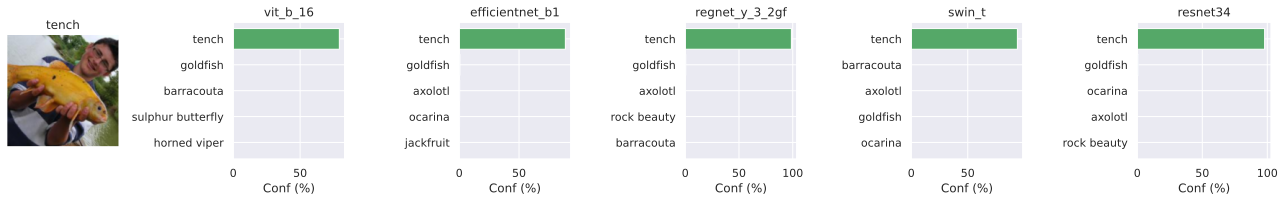

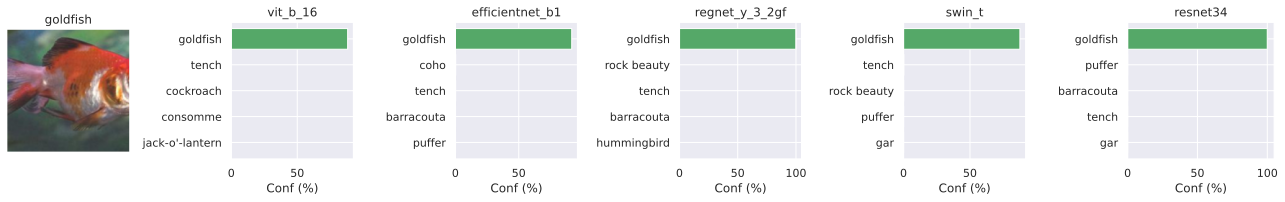

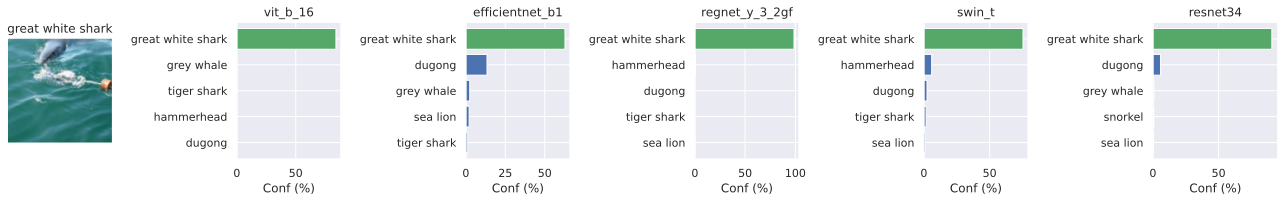

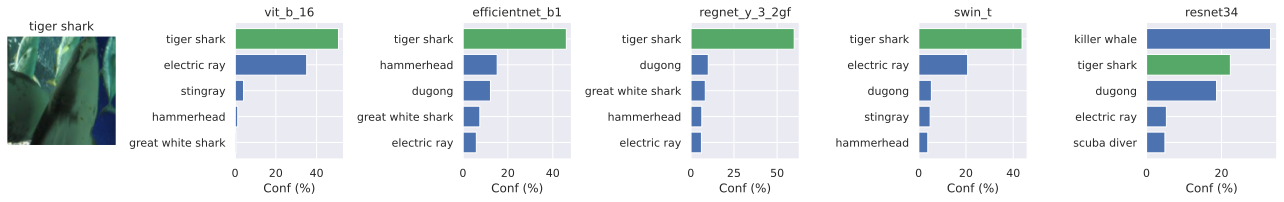

In [50]:
# Example: show image #5 in the batch with predictions from all selected models
for i in range(1,17,5):
    show_multi_model_prediction(exmp_batch[i], label_batch[i], {k: v[0] for k,v in models_loaders.items()})

The bar plot on the right shows the top-5 predictions of the model with their class probabilities. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise, we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.

### Adversarial Patches

Instead of changing every pixel by a little bit, we can also try to change a small part of the image into whatever values we would like. In other words, we will create a small image patch that covers a minor part of the original image but causes the model to confidentially predict a specific class we choose. This form of attack is an even bigger threat in real-world applications than FSGM. Imagine a network in an autonomous car that receives a live image from a camera. Another driver could print out a specific pattern and put it on the back of his/her vehicle to make the autonomous car believe that the car is actually a pedestrian. Meanwhile, humans would not notice it. [Tom Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) proposed a way of learning such adversarial image patches robustly in 2017 and provided a short demonstration on [YouTube](https://youtu.be/i1sp4X57TL4). Interestingly, if you add a small picture of the target class (here *toaster*) to the original image, the model does not pick it up at all. A specifically designed patch, however, which only roughly looks like a toaster, can change the network's prediction instantaneously.

[![Adversarial patch in real world](https://img.youtube.com/vi/i1sp4X57TL4/0.jpg)](https://youtu.be/i1sp4X57TL4)

Let's take a closer look at how we can actually train such patches. We calculate gradients for the input, and update our adversarial input correspondingly. We do not calculate a gradient for every pixel. Instead, we replace parts of the input image with our patch and then calculate the gradients just for our patch. Secondly, we don't just do it for one image, but we want the patch to work with any possible image. Hence, we have a whole training loop where we train the patch using SGD. Lastly, image patches are usually designed to make the model predict a specific class, not just any other arbitrary class except the true label. For instance, we can try to create a patch for the class "toaster" and train the patch so that our pretrained model predicts the class "toaster" for any image with the patch in it.

[Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) randomly rotated and scaled the patch during training before placing it at a random position in an input image. This makes the patch more robust to small changes and is necessary if we want to fool a neural network in a real-world application.

This tutorial only shows how to make the patch robust to the location in the image.

Here is where you could:
* Randomly rotate patch
* Randomly scale the patch
* Improve random location of patch in the image

In [91]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The patch itself will be an `nn.Parameter` whose values are in the range between $-\infty$ and $\infty$. Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet:

In [92]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # ensure means/std are on the same device as patch
    means = TENSOR_MEANS.to(patch.device)
    stds = TENSOR_STD.to(patch.device)
    patch = (torch.tanh(patch) + 1 - 2 * means) / (2 * stds)
    return patch

Before looking at the actual training code, we can write a small evaluation function. We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below.

In [85]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Finally, we can look at the training loop. Given a model to fool, a target class to design the patch for, and a size $k$ of the patch in the number of pixels, we first start by creating a parameter of size $3\times k\times k$. These are the only parameters we will train, and the network itself remains untouched. We use a simple SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. While we first start with a very high loss due to the good initial performance of the network, the loss quickly decreases once we start changing the patch. In the end, the patch will represent patterns that are characteristic of the class. For instance, if we would want the model to predict a "goldfish" in every image, we would expect the pattern to look somewhat like a goldfish. Over the iterations, the model finetunes the pattern and, hopefully, achieves a high fooling accuracy.

In [107]:
import os
import csv
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from tqdm import tqdm

# Helpers
def _ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def _save_patch_tensor(patch_tensor, path):
    torch.save(patch_tensor, path)

def _save_patch_visual(patch_tensor, path):
    p = patch_tensor.detach().cpu().clone()
    mn, mx = float(p.min()), float(p.max())
    if mx - mn > 1e-8:
        p_vis = (p - mn) / (mx - mn)
    else:
        p_vis = torch.clamp(p * 0 + 0.5, 0.0, 1.0)
    save_image(p_vis, path)

# Augmentation utilities applied to the patch (patch is CxH xW)
def random_rotate_patch(patch, max_angle=30.0):
    # patch: Tensor C,H,W on CPU or device; TF.rotate expects PIL or tensor in 3D with torchvision >=0.8
    angle = float(torch.empty(1).uniform_(-max_angle, max_angle).item())
    return TF.rotate(patch, angle, expand=False, interpolation=TF.InterpolationMode.BILINEAR)

def random_scale_patch(patch, scale_min=0.5, scale_max=1.5, min_size=1):
    scale = float(torch.empty(1).uniform_(scale_min, scale_max).item())
    C, H, W = patch.shape
    new_h = max(min_size, int(round(H * scale)))
    new_w = max(min_size, int(round(W * scale)))
    patch_scaled = F.interpolate(patch.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False)
    return patch_scaled.squeeze(0)

def place_patch_on_image(img_batch, patch_tensor, top, left):
    # img_batch: B x C x H x W
    # patch_tensor: C x pH x pW (assumed on same device)
    B, C, H, W = img_batch.shape
    pC, pH, pW = patch_tensor.shape
    assert C == pC, "Channel mismatch"

    out = img_batch.clone()
    for i in range(B):
        th, tl = top[i].item(), left[i].item()
        # safety bounds
        ph = min(pH, H - th)
        pw = min(pW, W - tl)
        if ph <= 0 or pw <= 0:
            continue
        out[i, :, th:th+ph, tl:tl+pw] = patch_tensor[:, :ph, :pw]
    return out

def place_patch_with_augmentation(img_batch, base_patch, rot_range=30.0, scale_range=(0.75, 1.25),
                                  placement_margin=0, device=None):
    """
    For each image in img_batch, sample a random rotation and scale of base_patch, then place at a random pos.
    Returns patched batch. base_patch is a Parameter or Tensor CxH xW on device (leaf must be preserved externally).
    """
    if device is None:
        device = img_batch.device
    B, C, H, W = img_batch.shape

    patched_batch = img_batch.clone()

    # We'll create augmented patches on-device
    for i in range(B):
        # 1) rotate
        patch = base_patch
        # random rotate and scale operate on tensors; ensure they accept device tensors
        patch_aug = random_rotate_patch(patch, max_angle=rot_range)

        # 2) scale
        smin, smax = scale_range
        patch_aug = random_scale_patch(patch_aug, scale_min=smin, scale_max=smax)

        pC, pH, pW = patch_aug.shape

        # 3) random placement: choose top,left such that patch fits entirely inside the image, optionally with margin
        max_top = max(0, H - pH - placement_margin)
        max_left = max(0, W - pW - placement_margin)
        top = torch.randint(low=placement_margin, high=max_top+1, size=(1,))
        left = torch.randint(low=placement_margin, high=max_left+1, size=(1,))

        # if patch is larger than image, center-crop the patch to image size
        if pH > H or pW > W:
            start_h = max(0, (pH - H)//2)
            start_w = max(0, (pW - W)//2)
            patch_aug = patch_aug[:, start_h:start_h+H, start_w:start_w+W]
            pH, pW = patch_aug.shape[1], patch_aug.shape[2]
            top = torch.tensor([0])
            left = torch.tensor([0])

        # Place (convert to same device)
        patch_aug = patch_aug.to(device)
        patched_batch[i:i+1] = place_patch_on_image(patched_batch[i:i+1], patch_aug, top, left)

    return patched_batch

# Main training function (integrates augmentation)
def patch_attack_multiple_models_and_save_with_augs(
    selected_model_keys,
    target_class,
    patch_size=64,
    num_epochs=50,
    batch_size=32,
    out_dir=CHECKPOINT_PATH,
    save_visual=True,
    num_workers_train=2,
    num_workers_val=1,
    rot_range=30.0,
    scale_range=(0.75, 1.25),
    placement_margin=0
):
    """
    Train per-model adversarial patches with random rotation+scaling+random placement,
    saving patch tensors and visuals per model/class/size.
    Returns results_dict and csv path.
    """
    _ensure_dir(out_dir)
    patches_dir = os.path.join(out_dir, "trained_patches")
    _ensure_dir(patches_dir)

    csv_path = os.path.join(out_dir, "patch_results.csv")
    csv_fieldnames = ["model_key", "target_class", "patch_size", "patch_pt", "patch_png", "top1_acc", "top5_acc"]

    results_dict = {}

    with open(csv_path, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_fieldnames)
        writer.writeheader()

        for key in selected_model_keys:
            print(f"\n=== Training patch for {key} (target {target_class}) ===")
            model, loader, weights = get_model_and_dataloader(key, batch_size=batch_size, shuffle=True)

            dataset_full = loader.dataset
            n_total = len(dataset_full)
            n_train = int(0.9 * n_total)
            n_val = n_total - n_train
            train_set, val_set = torch.utils.data.random_split(dataset_full, [n_train, n_val])

            train_loader = torch.utils.data.DataLoader(
                train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers_train
            )
            val_loader = torch.utils.data.DataLoader(
                val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers_val
            )

            # Create patch Parameter as true device leaf
            if not isinstance(patch_size, tuple):
                patch_h, patch_w = patch_size, patch_size
            else:
                patch_h, patch_w = patch_size

            patch = torch.nn.Parameter(torch.zeros(3, patch_h, patch_w, device=device), requires_grad=True)
            optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
            loss_module = torch.nn.CrossEntropyLoss()

            # Training loop with augmentations applied on the fly
            for epoch in range(num_epochs):
                t = tqdm(train_loader, leave=False)
                for img_batch, _ in t:
                    img_batch = img_batch.to(device, non_blocking=True)
                    # apply randomized augmentation to patch and place
                    patched = place_patch_with_augmentation(
                        img_batch, patch,
                        rot_range=rot_range, scale_range=scale_range,
                        placement_margin=placement_margin, device=device
                    )
                    preds = model(patched)
                    labels = torch.zeros(img_batch.shape[0], device=preds.device, dtype=torch.long).fill_(target_class)
                    loss = loss_module(preds, labels)
                    optimizer.zero_grad()
                    loss.mean().backward()
                    optimizer.step()
                    t.set_description(f"{key} | Epoch {epoch}, Loss: {loss.item():.4f}")
                # after finishing one epoch, evaluate current patch
                acc, top5 = eval_patch(model, patch, val_loader, target_class)
                print(f"[EVAL] epoch={epoch}  top1={acc:.4f}  top5={top5:.4f}")

            # Evaluate final patch on validation set (use deterministic placement: center)
            # Create an eval wrapper that places the original patch centered (or random with fixed seed)
            def eval_place_fn(batch_imgs, patch_param):
                # center placement for eval (no rotation/scale)
                B, C, H, W = batch_imgs.shape
                p = patch_param
                pH, pW = p.shape[1], p.shape[2]
                top = (H - pH) // 2
                left = (W - pW) // 2
                tops = torch.tensor([top]*B)
                lefts = torch.tensor([left]*B)
                return place_patch_on_image(batch_imgs, p.to(device), tops, lefts)

            acc, top5 = eval_patch(model, patch, val_loader, target_class, place_fn=eval_place_fn) \
                        if "place_fn" in eval_patch.__code__.co_varnames else eval_patch(model, patch, val_loader, target_class)

            results_dict[key] = {"patch": patch.detach().cpu().clone(), "acc": acc.item(), "top5": top5.item()}

            # persist (unique filename)
            size_str = f"{patch_h}x{patch_w}"
            base_name = f"{key}_class{target_class}_patch_{size_str}"
            patch_pt_path = os.path.join(patches_dir, base_name + ".pt")
            _save_patch_tensor(results_dict[key]["patch"], patch_pt_path)

            patch_png_path = ""
            if save_visual:
                patch_png_path = os.path.join(patches_dir, base_name + ".png")
                try:
                    _save_patch_visual(results_dict[key]["patch"], patch_png_path)
                except Exception:
                    p = results_dict[key]["patch"]
                    p_vis = torch.clamp((p + 1.0) / 2.0, 0.0, 1.0)
                    save_image(p_vis, patch_png_path)

            writer.writerow({
                "model_key": key,
                "target_class": target_class,
                "patch_size": size_str,
                "patch_pt": patch_pt_path,
                "patch_png": patch_png_path,
                "top1_acc": acc.item(),
                "top5_acc": top5.item()
            })
            csvfile.flush()

    print(f"\nSaved patches into: {patches_dir}")
    print(f"CSV summary saved at: {csv_path}")
    return results_dict, csv_path


In [ ]:
CUSTOM_CHECKPOINT_PATH_ALEJANDRO='/content/alejandro_models'
selected_models=['resnet34']

for i in [30,39,430,435,508]:
  for path_size in [48, 64,128]:
    patch_results = patch_attack_multiple_models_and_save_with_augs(selected_models, target_class=i, patch_size=path_size, num_epochs=10, out_dir=CUSTOM_CHECKPOINT_PATH_ALEJANDRO)


=== Training patch for resnet34 (target 30) ===


[EVAL] epoch=0  top1=0.0000  top5=0.0025


[EVAL] epoch=1  top1=0.0000  top5=0.0000


[EVAL] epoch=2  top1=0.0000  top5=0.0015


[EVAL] epoch=3  top1=0.0000  top5=0.0050


[EVAL] epoch=4  top1=0.6440  top5=0.8070


[EVAL] epoch=5  top1=0.7585  top5=0.8835


[EVAL] epoch=6  top1=0.7530  top5=0.8865


[EVAL] epoch=7  top1=0.7310  top5=0.8765


[EVAL] epoch=8  top1=0.6695  top5=0.8445


[EVAL] epoch=9  top1=0.6845  top5=0.8450



Saved patches into: /content/alejandro_models/trained_patches
CSV summary saved at: /content/alejandro_models/patch_results.csv

=== Training patch for resnet34 (target 30) ===


[EVAL] epoch=0  top1=0.0000  top5=0.0025


[EVAL] epoch=1  top1=0.0010  top5=0.0150


[EVAL] epoch=2  top1=0.8677  top5=0.9639


[EVAL] epoch=3  top1=0.9143  top5=0.9860


[EVAL] epoch=4  top1=0.9344  top5=0.9850


[EVAL] epoch=5  top1=0.9374  top5=0.9910


[EVAL] epoch=6  top1=0.9439  top5=0.9945


[EVAL] epoch=7  top1=0.9414  top5=0.9940


[EVAL] epoch=8  top1=0.9489  top5=0.9960


[EVAL] epoch=9  top1=0.9449  top5=0.9945



Saved patches into: /content/alejandro_models/trained_patches
CSV summary saved at: /content/alejandro_models/patch_results.csv

=== Training patch for resnet34 (target 30) ===


[EVAL] epoch=0  top1=0.9990  top5=1.0000


[EVAL] epoch=1  top1=0.9990  top5=1.0000


resnet34 | Epoch 2, Loss: 0.0299:  46%|████▌     | 64/140 [00:12<00:15,  4.86it/s]

Before looking at the quantitative results, we can actually visualize the patches.

We can see a clear difference between patches of different classes and sizes. In the smallest size, $32\times 32$ pixels, some of the patches clearly resemble their class. For instance, the goldfish patch clearly shows a goldfish. The eye and the color are very characteristic of the class. Overall, the patches with $32$ pixels have very strong colors that are typical for their class (yellow school bus, pink lipstick, greenish pineapple). The larger the patch becomes, the more stretched the pattern becomes. For the goldfish, we can still spot regions that might represent eyes and the characteristic orange color, but it is not clearly a single fish anymore. For the pineapple, we might interpret the top part of the image as the leaves of pineapple fruit, but it is more abstract than our small patches. Nevertheless, we can easily spot the alignment of the patch to class, even on the largest scale.

Let's now look at the quantitative results.

In [68]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [19]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction?

In [20]:
show_table(top_1=True)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
toaster,48.89%,90.48%,98.58%
goldfish,69.53%,93.53%,98.34%
school bus,78.79%,93.95%,98.22%
lipstick,43.36%,86.05%,96.41%
pineapple,79.74%,94.48%,98.72%


The clear trend, that we would also have expected, is that the larger the patch, the easier it is to fool the model. For the largest patch size of $64\times 64$, we are able to fool the model on almost all images, despite the patch covering only 8% of the image. The smallest patch actually covers 2% of the image, which is almost neglectable. Still, the fooling accuracy is quite remarkable. A large variation can be however seen across classes. While *school bus* and *pineapple* seem to be classes that were easily predicted, *toaster* and *lipstick* seem to be much harder for creating a patch. It is hard to intuitively explain why our patches underperform on those classes. Nonetheless, a fooling accuracy of >40% is still very good for such a tiny patch.

Let's also take a look at the top-5 accuracy:

In [21]:
show_table(top_1=False)

Class name,Patch size 32x32,Patch size 48x48,Patch size 64x64
toaster,72.02%,98.12%,99.93%
goldfish,86.31%,99.07%,99.95%
school bus,91.64%,99.15%,99.89%
lipstick,70.10%,96.86%,99.73%
pineapple,92.23%,99.26%,99.96%


We see a very similar pattern across classes and patch sizes. The patch size $64$ obtains >99.7% top-5 accuracy for any class, showing that we can almost fool the network on any image. A top-5 accuracy of >70% for the hard classes and small patches is still impressive and shows how vulnerable deep CNNs are to such attacks.

Finally, let's create some example visualizations of the patch attack in action.

In [106]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# helpers: unnormalize for display
NORM_MEAN = torch.tensor(NORM_MEAN) if not isinstance(NORM_MEAN, torch.Tensor) else NORM_MEAN
NORM_STD  = torch.tensor(NORM_STD)  if not isinstance(NORM_STD, torch.Tensor) else NORM_STD

def unnormalize_image(tensor_img):
    # tensor_img: C x H x W in normalized space (torch.float)
    img = tensor_img.detach().cpu().clone()
    img = img * NORM_STD[:, None, None] + NORM_MEAN[:, None, None]
    img = torch.clamp(img, 0.0, 1.0)
    return img



from PIL import Image
import numpy as np

def patched_tensor_to_pil(tensor):
    # tensor: C x H x W, normalized (float)
    img = unnormalize_image(tensor)  # still CxHxW, float in [0,1]
    img = (img * 255).byte()         # convert to uint8
    img = img.permute(1,2,0)         # H x W x C
    return Image.fromarray(img.cpu().numpy())


def show_image_tensor(tensor_img, title=None):
    img = unnormalize_image(tensor_img)
    # convert to H x W x C for matplotlib
    plt.figure(figsize=(20,20), dpi=600)
    plt.axis('off')
    plt.imshow(img.permute(1,2,0).numpy())
    # if title:
    #     plt.title(title)
    # plt.show()
    plt.savefig("test_figure.png")

def load_model_from_registry(model_key):
    entry = model_registry[model_key]
    model = entry["constructor"](weights=entry["weights"]).to(device)
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    return model

def load_patch(path, map_to_device=False):
    p = torch.load(path, map_location="cpu")
    # if saved as dict, try to extract first tensor entry
    if isinstance(p, dict):
        # common saved format: {"patch": tensor} or similar
        for v in p.values():
            if isinstance(v, torch.Tensor):
                p = v
                break
    if map_to_device:
        p = p.to(device)
    return p  # C x H x W on CPU by default

def get_random_sample_from_loader(val_loader):
    # pick a random batch, then a random index within it
    it = iter(val_loader)
    # advance a random number of batches (cheap sampler)
    skip = random.randint(0, max(0, len(val_loader)-1))
    for _ in range(skip):
        try:
            next(it)
        except StopIteration:
            break
    try:
        batch, labels = next(it)
    except StopIteration:
        batch, labels = next(iter(val_loader))
    # pick one index
    idx = random.randrange(batch.shape[0])
    return batch[idx:idx+1], labels[idx:idx+1]  # return as batch of size 1

def perform_patch_attack_on_random_image(model_key, patch_path, val_loader=None, exmp_batch=None, exmp_labels=None, topk=5):
    model = load_model_from_registry(model_key)
    patch = load_patch(patch_path, map_to_device=False)  # keep CPU, place_patch will move
    # choose sample
    if exmp_batch is not None and exmp_labels is not None:
        sample_batch = exmp_batch.clone()
        sample_labels = exmp_labels.clone()
        sample_batch = sample_batch[:1]
        sample_labels = sample_labels[:1]
    else:
        assert val_loader is not None, "Either provide val_loader or exmp_batch/exmp_labels"
        sample_batch, sample_labels = get_random_sample_from_loader(val_loader)

    # place patch (non-destructive)
    patched = place_patch(sample_batch.clone(), patch)  # place_patch should handle device movement
    # ensure patched on device
    patched_dev = patched.to(device, non_blocking=True)
    # forward
    with torch.no_grad():
        logits = model(patched_dev)
        probs = F.softmax(logits, dim=-1)
        topk_vals, topk_idx = probs.topk(topk, dim=-1)

    # print results
    print("Ground-truth label:", int(sample_labels.item()))
    topk_vals = topk_vals.cpu().numpy().squeeze()
    topk_idx  = topk_idx.cpu().numpy().squeeze()
    for rank, (cls, val) in enumerate(zip(topk_idx, topk_vals), start=1):
        print(f"Top{rank}: class={int(cls)} prob={float(val):.4f}")

    # show patched image (first item)
    # show_image_tensor(patched[0], title=f"Patched sample (model={model_key})")
    patched_tensor_to_pil(patched[0]).save("test_figure.png")
    return patched, logits, probs


# Example usage:
# Provide your validation loader for the corresponding model preprocessing
_, val_loader, _ = get_model_and_dataloader("resnet34", batch_size=64, shuffle=False)

patch_path = "/content/alejandro_models/trained_patches/resnet34_patch_(48, 48).pt"  # change to your file
patched, logits, probs = perform_patch_attack_on_random_image("resnet34", patch_path, val_loader=val_loader)


Ground-truth label: 4
Top1: class=30 prob=0.5035
Top2: class=389 prob=0.2770
Top3: class=4 prob=0.1000
Top4: class=5 prob=0.0306
Top5: class=3 prob=0.0225


## References

This tutorial was originally created by Phillip Lippe.
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.